# Project Notebook




The task is to produce a neural process which is tailored to solve a physical system.  In this case, the physical system to be solved is the heat diffusion across a two-dimensional grid.  There are three main changes I wish to make to the standard neural process.  These are listed below, along with a brief description of their physical motivation.

#### 1. Convolutional Encoder and Decoder block 
Spatial equivariance is built into the system, since the heat diffusion function does not have a spatially dependent forcing term.  All terms are based on derivatives, which means the solution obeys spatial equivariance.  I hope to replicate this feature in the architecture, allowing for an easier learning process.
#### 2. Learning using Privileged Information
Learning using privileged information (LUPI) allows the model, while training, to have access to 'privileged information' (PI).  PI could be anything important the model should be aware of.  For example, if the total energy in the grid is conserved, imput this as PI.  When it comes to test time, the model does not have access to any PI.  The hope is that the model can infer what the PI should be (e.g. by figuring out what the total energy is and conserving it), making for a faster learning process.  There is a wide variety of PI to be used and experimented with.  A few more examples are: initial conditions, final conditions, decay constant, entropy measure.

The way the PI is implemented is through an encoder which runs separately to the usual encoder.  The PI embedding is then aggregated with the embedding of the data using a residual neural network; we do not want the PI to dominate the learning, but merely to add a `first order correction' to the learning process.  The good thing about this structure is that the PI can be added to any encoder block (e.g. flat encoder or convolutional encoder)

#### 3. Future...Time-Order Respecting Aggregator
In a neural process, the embeddings of the data at different times, $t_i$, are aggregated with a permutation invariant aggregator.  This is not usually useful for physical processes, as there tends to be a time-respecting process such as increase in entropy (in this case, diffusion of heat).  Therefore, it might be useful to reflect this in the aggregator.  The aggregator is such that there is no information leak from future to past - it imposes causality.

The aggregator could also be designed to reflect temporal equivariance, for the same reasons as the spatial equivariance: the diffusion equation involves no terms which depend explicitly on time, but rather only the derivative with resepct to time.  If the model is temporally equivariant, it may perform much better on extrapolation tasks (as it is not completely `blind' when it heads out of the sample, having learnt temporal behaviour)

One possible choice for this is to allow the model to `learn' these features by implementing a multi-head attention network.  However, with this option there is far less control over which physical concepts I am imposing.


I hope these three changes will improve on the most basic vanilla neural process architecture to learn the heat diffusion behaviour over a two-dimensional grid, as they are all grounded in physical concepts. 

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from scipy.integrate import odeint


# grab the neural process functions from Emilien Dupont's library called neural-processes
import sys

sys.path.insert(0, "./neural-processes")

# neural_process.py and training.py exist in neural-processes folder
import neural_process
from neural_process import NeuralProcessConv, NeuralProcess
from training import NeuralProcessTrainer
from utils import context_target_split
from heat_diffusion_dataset import Initial_Conditions, Diffusion_Data, RestoredData
from visualise import *

import matplotlib as mpl

mpl.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.size": 18,
        "figure.figsize": [8, 6],
        "lines.linewidth": 1,
        "lines.markersize": 8,
        "legend.fontsize": "medium",
        "axes.labelsize": "medium",
        "xtick.labelsize": "medium",
        "ytick.labelsize": "medium",
    }
)



/usr/local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/usr/local/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/usr/local/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/usr/local/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")


# Diffusion Data

Heat Diffusion data was chosen as a suitable dataset to test my model.  The equation which the data follows is 

\begin{equation}
\frac{\partial u(x, y, t)}{\partial t} = D \nabla^2 u(x, y, t)
\end{equation} 

The boundary conditions are chosen to be Neumann Boundary Conditions, specifying the normal gradient to be zero at the boundaries

\begin{equation}
\left. \frac{\partial u}{\partial x} \right|_{x = 0, L} = \left. \frac{\partial u}{\partial y}\right|_{y=0, L} = 0
\end{equation}

These boundary conditions ensure heat remains inside the grid and cannot escape (the flux through the boundary is zero).  There are no sources or sinks, so the total heat energy in the grid is conserved.

The variation between datasets lies in the initial conditions.  There are three parameters for the initial conditions which are changed. 
1. Initial temperature 
2. Location of initial temperature spike
3. Broadness of initial temperature spike 

The overall heat energy in the grid therefore can change from dataset to dataset, but remains constant within each one.  The diffusion coefficient is also the same for each dataset.  This could replicate, for example, heat diffusion in a fixed medium with varying initial conditions.

Finite difference method (FDM) is used to solve equation 1.  The Laplacian is calculated using the five-point stencil finite difference method *Appendix.  This posed a difficulty when the initial conditions contained a discontinuous jump in temperature because Laplacian would become very large near the jump points.  To solve this issue, instead of implementing a different more advanced solver such as finite element methods (which may take a longer time to compute), a Gaussian filter was applied to smooth the initial conditions *Appendix.  The Gaussian filter was imported from `scipy.ndimage` module.

FDM becomes unstable when $\Delta t \leq \frac{\Delta x^2}{4D}$ *appendix, reference

In [28]:
dimensions = {
    't_dim' : 1,
    'y_dim' : 2500,
    'r_dim' : 128,
    'h_dim' : 128,
    'z_dim' : 128,
    'max_iter_time' : 500,
    'grid_size' : 50,
    'num_samples' : 40,
    'num_context' : 30,
    'num_target' : 30,
    'batch_size' : 2,
    'num_channels' : 16,
    'pi_dim' : 4
}

assert dimensions['grid_size']**2 == dimensions['y_dim']
assert dimensions['num_context'] + dimensions['num_target'] <= dimensions['max_iter_time']

# parameters
grid_size = dimensions['grid_size']
num_samples = dimensions['num_samples']
square_range = (5, 15) # side length of initial hot square
temp_range = (1.0, 2.0)
diffusion_coef = 0.25 * dimensions['max_iter_time'] # upper limit for stable FDM solver

assert diffusion_coef <= 0.25 * dimensions['max_iter_time']

In [3]:
''' 
RUN TO RE-GENERATE DATA
'''
# Abstraction classes to make data in readable format
class MetaData():
    def __init__(self, meta_data, ds_num):
        # Only access first data set in the meta-dataset 
        self.t = meta_data[ds_num][0]
        self.y = meta_data[ds_num][1]
        self.pi = meta_data[ds_num][2]

class Pi():
    def __init__(self, pi):
        self.diffusion_coef = pi[:, 0]
        self.max_temp = pi[:, 1]
        self.energy = pi[:, 2]
        self.entropy = pi[:, 3]


initial_conditions = Initial_Conditions(
    max_iter_time=dimensions['max_iter_time'], grid_size=grid_size
)

meta_data = Diffusion_Data(
    num_samples=num_samples,
    max_iter_time=dimensions['max_iter_time'],
    grid_size=grid_size,
    initial_conditions=initial_conditions,
    square_range=square_range,
    temp_range=temp_range,
    diffusion_coef=diffusion_coef,
    sigma=3
)

time_array = meta_data.time_array

# meta_data.save_tensors()

/Users/alexking/Documents/part_III_project/./neural-processes/heat_diffusion_dataset.py:184: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1647.)
  entropy[np.isnan(entropy)] = 0


In [4]:
print(len(meta_data.data))
print(len(meta_data[0]))
print(meta_data[0][0].shape)
print(meta_data[0][1].shape)
print(meta_data[0][2].shape)

meta_data[4][2] == meta_data[3][2]

40
3
torch.Size([500, 1])
torch.Size([500, 2500])
torch.Size([500, 4])


tensor([[ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        ...,
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False]])

#### Visualize Target Data

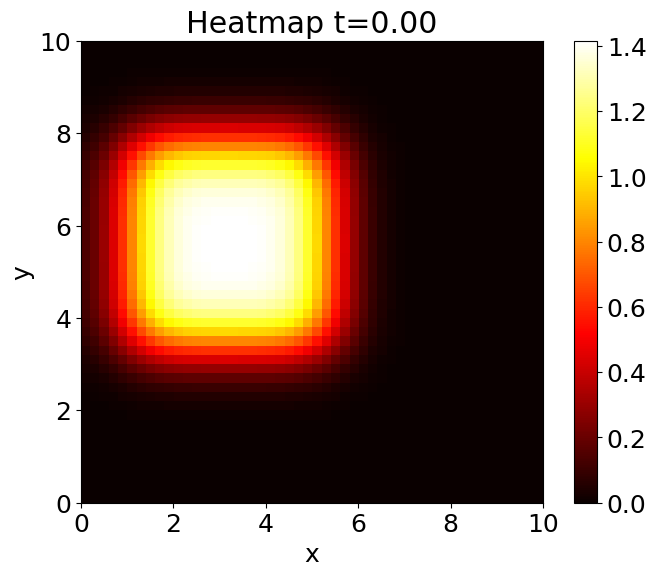

In [5]:
'''
Plot heatmap
'''

meta_data.visualise_solution(show_until=1, ds_num=3)


#### Privileged Information Data

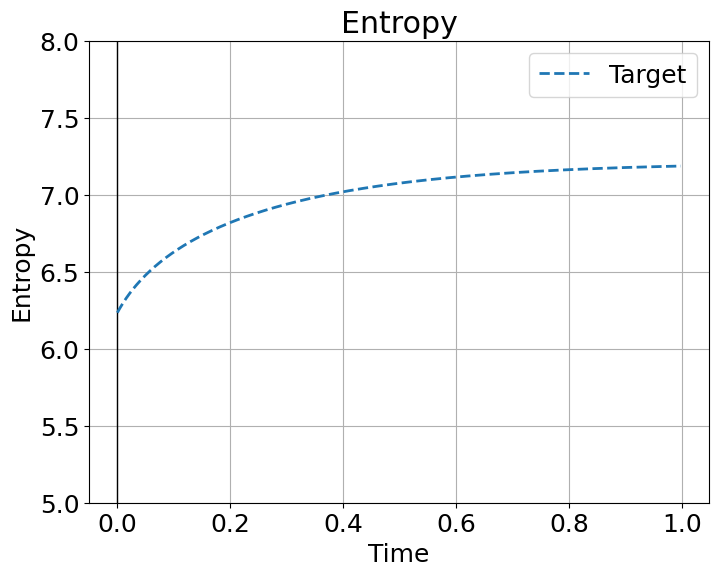

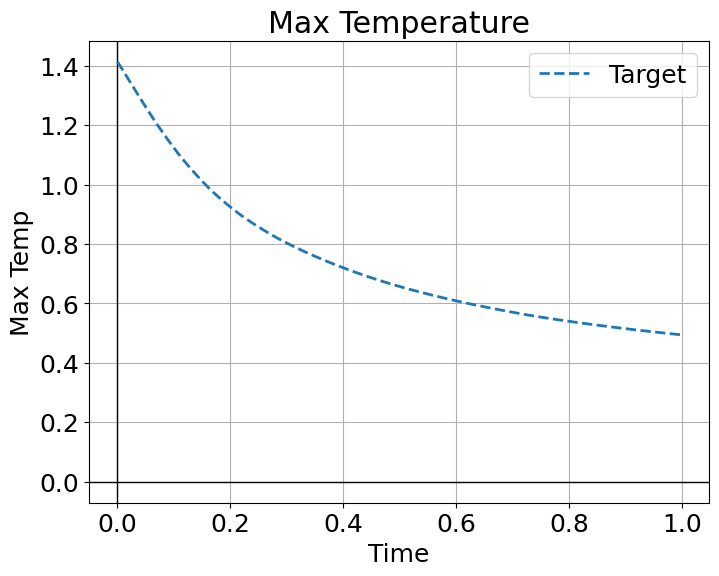

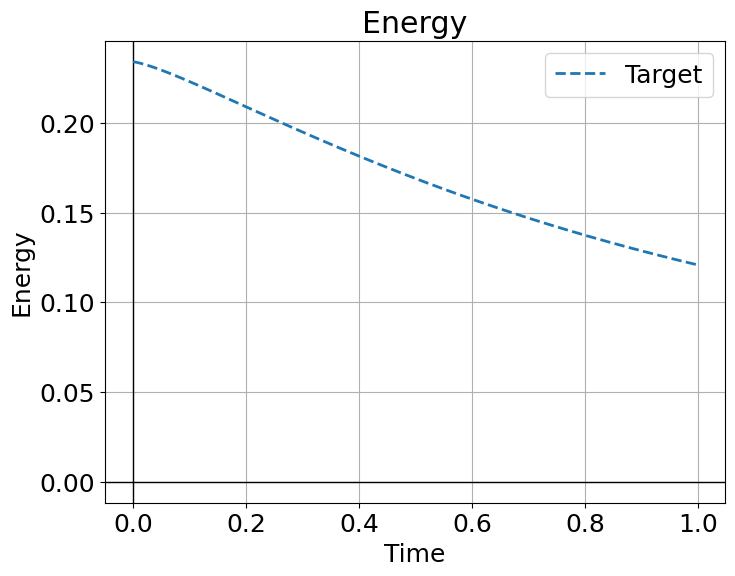

In [29]:
''' 
Plot privileged information
'''
out_entropy = torch.full((dimensions['max_iter_time'],), 0)
out_max_temp = torch.full((dimensions['max_iter_time'],), 0)
out_energy = torch.full((dimensions['max_iter_time'],), 0)

for ds_num in range(dimensions['num_samples']-1):
    ds = MetaData(meta_data.data, ds_num=ds_num)
    pi = Pi(ds.pi)
    out_entropy = out_entropy + pi.entropy
    out_max_temp = out_max_temp + pi.max_temp
    out_energy = out_energy + pi.energy
out_entropy = out_entropy / dimensions['num_samples']
out_max_temp = out_max_temp / dimensions['num_samples']
out_energy = out_energy / dimensions['num_samples']

plot_pi_data(out_entropy, np_mean=None, lupi_mean=None, conv_mean=None, title='Entropy', xlabel='Time', ylabel='Entropy')
plot_pi_data(out_max_temp, np_mean=None, lupi_mean=None, conv_mean=None, title='Max Temperature', xlabel='Time', ylabel='Max Temp')
plot_pi_data(out_energy, np_mean=None, lupi_mean=None, conv_mean=None, title='Energy', xlabel='Time', ylabel='Energy')


In [30]:
from models import Net, Encoder, Decoder, TransposedConvNet, LupiEncoder, RepresentationAggregator, MuSigmaEncoder

net = Net(dimensions)
encoder = Encoder(dimensions)
decoder = Decoder(dimensions)
transposedconvnet = TransposedConvNet(dimensions)
lupi_encoder = LupiEncoder(dimensions)
representation_aggregator = RepresentationAggregator(dimensions)
mu_sigma_encoder = MuSigmaEncoder(dimensions)

all_models = {
    'net' : net,
    'encoder': encoder,
    'decoder': decoder,
    'transposedconvnet':transposedconvnet,
    'lupi_encoder':lupi_encoder,
    'representation_aggregator':representation_aggregator,
    'mu_sigma_encoder':mu_sigma_encoder
}


def count_model_params(model):
    return sum(p.numel() for p in model.parameters(model) if p.requires_grad)

for k, v in all_models.items():
    print('model {} has {} parameters'.format(k, count_model_params(v)))

np_params = (
    count_model_params(all_models['encoder']) 
    + count_model_params(all_models['mu_sigma_encoder']) 
    + count_model_params(all_models['decoder'])
)

lupi_params = (
    count_model_params(all_models['encoder']) 
    + count_model_params(all_models['mu_sigma_encoder']) 
    + count_model_params(all_models['lupi_encoder']) 
    + count_model_params(all_models['representation_aggregator']) 
    + count_model_params(all_models['decoder'])
)

conv_params = (
    count_model_params(all_models['net']) 
    + count_model_params(all_models['mu_sigma_encoder']) 
    + count_model_params(all_models['decoder']) 
)


print('NP has {} learnable parameters'.format(np_params))
print('LUPI has {} learnable parameters'.format(lupi_params))
print('Conv has {} learnable parameters'.format(conv_params))

model net has 18294 parameters
model encoder has 353280 parameters
model decoder has 694664 parameters
model transposedconvnet has 19462 parameters
model lupi_encoder has 33792 parameters
model representation_aggregator has 65920 parameters
model mu_sigma_encoder has 49536 parameters
NP has 1097480 learnable parameters
LUPI has 1197192 learnable parameters
Conv has 762494 learnable parameters


## Neural Process

In [26]:
from torch.autograd import profiler
profiler.profile(enabled=True)
reps = 10

overall_time = np.full((reps,), -1)

for i in range(reps):
    with profiler.profile() as prof:

        np_test = NeuralProcessConv(dimensions)

        dl = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)
        op = torch.optim.Adam(np_test.parameters(), lr=1e-4)
        trainer_test = NeuralProcessTrainer(
            "cuda",
            np_test,
            op,
            num_context_range=(dimensions['num_context'], dimensions['num_context']),
            num_extra_target_range=(dimensions['num_target'], dimensions['num_target']),
            print_freq=1000,
            grid_size=dimensions['grid_size']
        )

        np_test.training = True
        trainer_test.train(dl, 1)
            
    result = prof.self_cpu_time_total
    # Extract overall time taken
    overall_time[i] = result
    # profiler.profile(enabled=False)
    # print(prof.key_averages().table(sort_by="self_cpu_time_total"))
print('NP average time taken is {} ± {} ms'.format(overall_time.mean() / 1000, overall_time.std() / 1000))

# torch.save(neuralprocess.state_dict(), './trainers/neuralprocess_dict')
# torch.save(np_trainer.epoch_loss_history, './metadata/epoch_loss_history')


STAGE:2023-05-10 15:46:46 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98758.87109375


STAGE:2023-05-10 15:46:48 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:46:56 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98645.1109375


STAGE:2023-05-10 15:46:58 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:05 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98676.72265625


STAGE:2023-05-10 15:47:06 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:13 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98638.362890625


STAGE:2023-05-10 15:47:15 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:23 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98809.796875


STAGE:2023-05-10 15:47:24 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:31 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98355.65234375


STAGE:2023-05-10 15:47:33 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:40 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98885.8984375


STAGE:2023-05-10 15:47:41 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:50 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98808.39921875


STAGE:2023-05-10 15:47:52 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:47:59 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98901.808203125


STAGE:2023-05-10 15:48:01 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-05-10 15:48:08 2227:6709414 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Epoch: 0, Avg_loss: 98850.46640625


STAGE:2023-05-10 15:48:10 2227:6709414 ActivityProfilerController.cpp:300] Completed Stage: Collection


NP average time taken is 1241.358 ± 106.78075874238768 ms


## CONVOLUTIONAL ENCODER 

In [8]:
conv_neuralprocess = NeuralProcessConv(dimensions)

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)
optimizer = torch.optim.Adam(conv_neuralprocess.parameters(), lr=1e-4)
conv_np_trainer = NeuralProcessTrainer(
    "cuda",
    conv_neuralprocess,
    optimizer,
    num_context_range=(dimensions['num_context'], dimensions['num_context']),
    num_extra_target_range=(dimensions['num_target'], dimensions['num_target']),
    print_freq=1000,
    grid_size=dimensions['grid_size'],
)

conv_neuralprocess.training = True
conv_np_trainer.train(data_loader, 2000)

# print(prof.key_averages().table(sort_by="self_cpu_time_total"))

torch.save(conv_neuralprocess.state_dict(), './trainers/conv_neuralprocess_dict_test')
torch.save(conv_np_trainer.epoch_loss_history, './metadata/conv_epoch_loss_history_test')


Epoch: 0, Avg_loss: 98863.846484375
Epoch: 1, Avg_loss: 97372.665625
Epoch: 2, Avg_loss: 94482.26015625
Epoch: 3, Avg_loss: 84252.281640625
Epoch: 4, Avg_loss: 61633.7123046875
Epoch: 5, Avg_loss: 33065.548712158205
Epoch: 6, Avg_loss: 4055.6585693359375
Epoch: 7, Avg_loss: -8906.938159179688
Epoch: 8, Avg_loss: -21388.369941711426
Epoch: 9, Avg_loss: -23971.538787841797
Epoch: 10, Avg_loss: -29222.19189453125
Epoch: 11, Avg_loss: -31769.974267578124
Epoch: 12, Avg_loss: -33049.84340820312
Epoch: 13, Avg_loss: -38650.1048828125
Epoch: 14, Avg_loss: -33075.583340454104
Epoch: 15, Avg_loss: -35256.22661743164
Epoch: 16, Avg_loss: -39464.06545410156
Epoch: 17, Avg_loss: -41730.84633789062
Epoch: 18, Avg_loss: -36085.6677734375
Epoch: 19, Avg_loss: -36827.79697265625
Epoch: 20, Avg_loss: -39754.861083984375
Epoch: 21, Avg_loss: -45189.830715942386
Epoch: 22, Avg_loss: -38101.19098510742
Epoch: 23, Avg_loss: -32530.699829101562
Epoch: 24, Avg_loss: -44981.82819824219
Epoch: 25, Avg_loss: -4

## LUPI

In [10]:
neuralprocess_pi = NeuralProcess(dimensions)

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)
optimizer = torch.optim.Adam(neuralprocess_pi.parameters(), lr=1e-4)
np_trainer_pi = NeuralProcessTrainer(
    "cuda",
    neuralprocess_pi,
    optimizer,
    num_context_range=(dimensions['num_context'], dimensions['num_context']),
    num_extra_target_range=(dimensions['num_target'], dimensions['num_target']),
    print_freq=1000,
    is_lupi=True
)

neuralprocess_pi.training = True
np_trainer_pi.train(data_loader, 2000)

torch.save(neuralprocess_pi.state_dict(), './trainers/neuralprocess_pi_dict')
torch.save(np_trainer_pi.epoch_loss_history, './metadata/lupi_epoch_loss_history')

Epoch: 0, Avg_loss: 97447.58125
Epoch: 1, Avg_loss: 95656.1078125
Epoch: 2, Avg_loss: 86159.012890625
Epoch: 3, Avg_loss: 63497.8705078125
Epoch: 4, Avg_loss: 33447.74471435547
Epoch: 5, Avg_loss: 11101.544924926759
Epoch: 6, Avg_loss: 285.8218335151672
Epoch: 7, Avg_loss: -5475.324398803711
Epoch: 8, Avg_loss: -13272.898870849609
Epoch: 9, Avg_loss: -19657.22686767578
Epoch: 10, Avg_loss: -22559.739135742188
Epoch: 11, Avg_loss: -25107.820727539063
Epoch: 12, Avg_loss: -23521.053680419922
Epoch: 13, Avg_loss: -24144.053442382814
Epoch: 14, Avg_loss: -24354.170428466798
Epoch: 15, Avg_loss: -31076.339364624022
Epoch: 16, Avg_loss: -31586.40615234375
Epoch: 17, Avg_loss: -28294.106024169923
Epoch: 18, Avg_loss: -36989.20990600586
Epoch: 19, Avg_loss: -36989.34389648437
Epoch: 20, Avg_loss: -36431.73311767578
Epoch: 21, Avg_loss: -38364.89236450195
Epoch: 22, Avg_loss: -43497.460131835935
Epoch: 23, Avg_loss: -38348.67397460937
Epoch: 24, Avg_loss: -45219.51617736816
Epoch: 25, Avg_loss:

# TESTING

#### Reload Models

In [114]:
# class Result():
#     def __init__(self, result):
#         self.pi
#         self.t
#         self.y_mean
#         self.y_var



In [9]:
neuralprocess = NeuralProcess(dimensions)
neuralprocess.load_state_dict(torch.load('./trainers/neuralprocess_dict'))

# conv_neuralprocess = NeuralProcess(dimensions)
# conv_neuralprocess.load_state_dict(torch.load('./trainers/conv_neuralprocess_dict'))

neuralprocess_pi = NeuralProcess(dimensions)
neuralprocess_pi.load_state_dict(torch.load('./trainers/neuralprocess_pi_dict'))

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)

#### Obtain Results from Test Data

In [10]:
def test_model(neuralprocess, t_context, y_context, t_target, y_target, dimensions=dimensions, noise=False):
    # Switch to test mode
    neuralprocess.training = False

    # Extract models' distributions over t_target and grid
    p_y_pred = neuralprocess(t_context, y_context, t_target)

    # flat NP
    y_mean = p_y_pred.loc.detach().numpy()[0]
    y_var = p_y_pred.scale.detach().numpy()[0]

    # flat NP reshape
    y_mean = y_mean.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))
    y_var = y_var.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))

    return y_target, torch.Tensor(y_mean), torch.Tensor(y_var)



In [11]:
# How many iterations to average the noise over 
noise_iters = 20

# Select which models to test
test_convolutional_neural_process = True
test_lupi_neural_process = True
test_flat_neural_process = True

batches = [batch for batch in data_loader]

# Use batch to create random set of context points
t, y, pi = batches[np.random.randint(0, len(batches))]
t_context, y_context, _, _, _, _ = context_target_split(
    t[0:1], y[0:1], pi[0:1], dimensions['num_context'], dimensions['num_target']
)

# Create a set of target points corresponding to in-sample time range
t_target = torch.linspace(0, 1, dimensions['max_iter_time'])
t_target = t_target.unsqueeze(1).unsqueeze(0)

# Extract mean of distribution
# t_out = t_target.numpy()[0]

# target output
y_target = y[0:1][0, :, :]
y_target = y_target.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))

if test_lupi_neural_process:
    y_target, lupi_y_mean, lupi_y_var = test_model(neuralprocess_pi, t_context, y_context, t_target, y_target)
    lupi_loss = torch.load('./metadata/lupi_epoch_loss_history')
    lupi_y_noise = torch.full((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']), 0)

    for iter in range(noise_iters):
        # generate random noise between 0 and 1 to feed as context
        white_noise = 1 * torch.rand(y_context.shape)
        lupi_y_noise = lupi_y_noise + test_model(neuralprocess_pi, t_context, white_noise, t_target, y_target, noise=True)[1]
    
    lupi_y_noise = lupi_y_noise / noise_iters
    
if test_flat_neural_process:
    y_target, y_mean, y_var = test_model(neuralprocess, t_context, y_context, t_target, y_target)
    loss = torch.load('./metadata/epoch_loss_history')
    y_noise = torch.full((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']), 0)

    for iter in range(noise_iters):
        # generate random noise between 0 and 1 to feed as context
        white_noise = 1 * torch.rand(y_context.shape)
        y_noise = y_noise + test_model(neuralprocess, t_context, white_noise, t_target, y_target, noise=True)[1]
    y_noise = y_noise / noise_iters

if test_convolutional_neural_process:
    y_target, conv_y_mean, conv_y_var = test_model(conv_neuralprocess, t_context, y_context, t_target, y_target)
    conv_loss = torch.load('./metadata/conv_epoch_loss_history_test')
    conv_y_noise = torch.full((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']), 0)

    for iter in range(noise_iters):
        # generate random noise between 0 and 1 to feed as context
        white_noise = 1 * torch.rand(y_context.shape)
        conv_y_noise = conv_y_noise + test_model(conv_neuralprocess, t_context, white_noise, t_target, y_target, noise=True)[1]
    conv_y_noise = conv_y_noise / noise_iters


#### Make sure data is in correct format

In [12]:
assert y_target.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert lupi_y_mean.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert lupi_y_var.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert lupi_y_noise.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert y_mean.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert y_var.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert y_noise.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert conv_y_mean.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert conv_y_var.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])
assert conv_y_noise.shape == (dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size'])

# Main Results

#### Metric 1: Mean Accuracy

- MSE
- Log Likelihood
- Time to compute

In [13]:
reps = 100
np_mse = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)
lupi_mse = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)
conv_mse = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)
np_log_likelihood = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)
lupi_log_likelihood = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)
conv_log_likelihood = torch.full((dimensions['grid_size'], dimensions['grid_size']), 0)

for i in range(reps):
    # Extract a batch from data_loader
    batches = [batch for batch in data_loader]

    # Use batch to create random set of context points
    t, y, pi = batches[np.random.randint(0, len(batches))]
    t_context, y_context, _, _, _, _ = context_target_split(
        t[0:1], y[0:1], pi[0:1], dimensions['num_context'], dimensions['num_target']
    )

    # Create a set of target points corresponding to in-sample time range
    t_target = torch.linspace(0, 1, dimensions['max_iter_time'])
    t_target = t_target.unsqueeze(1).unsqueeze(0)

    # target output
    y_target = y[0:1][0, :, :]
    y_target = y_target.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))

    y_target, y_mean, y_var = test_model(neuralprocess, t_context, y_context, t_target, y_target)
    y_target, lupi_y_mean, lupi_y_var = test_model(neuralprocess_pi, t_context, y_context, t_target, y_target)
    y_target, conv_y_mean, conv_y_var = test_model(conv_neuralprocess, t_context, y_context, t_target, y_target)
    
    np_performance = Performance(y_target, y_mean, y_var, dimensions)
    np_mse = np_mse + np_performance.residual() 
    np_log_likelihood = np_log_likelihood + np_performance.log_likelihood()
    
    lupi_performance = Performance(y_target, lupi_y_mean, lupi_y_var, dimensions)
    lupi_mse = lupi_mse + lupi_performance.residual() 
    lupi_log_likelihood = lupi_log_likelihood + lupi_performance.log_likelihood()

    conv_performance = Performance(y_target, conv_y_mean, conv_y_var, dimensions)
    conv_mse = conv_mse + conv_performance.residual()
    conv_log_likelihood = conv_log_likelihood + conv_performance.log_likelihood()

np_mse = np_mse / reps
lupi_mse = lupi_mse / reps
conv_mse = conv_mse / reps
np_log_likelihood = np_log_likelihood / reps
lupi_log_likelihood = lupi_log_likelihood / reps
conv_log_likelihood = conv_log_likelihood / reps

print(
    "FLAT NP: MSE accuracy was {:.8f}, with std {:.8f}".format(
        np_mse.mean(), np_mse.std()
    ))

print(
    "LUPI NP: MSE accuracy was {:.8f}, with std {:.8f}".format(
        lupi_mse.mean(), lupi_mse.std()
    ))


print(
    "CONVOLUTION: MSE accuracy was {:.8f}, with std {:.8f}".format(
        conv_mse.mean(), conv_mse.std()
    ))

print(
    "FLAT NP: log-likelihood was {:.8f}, with std {:.8f}".format(
        np_log_likelihood.mean(), np_log_likelihood.std()
    ))


print(
    "LUPI NP: log-likelihood was {:.8f}, with std {:.8f}".format(
        lupi_log_likelihood.mean(), lupi_log_likelihood.std()
    ))


print(
    "CONVOLUTION: log-likelihood was {:.8f}, with std {:.8f}".format(
        conv_log_likelihood.mean(), conv_log_likelihood.std()
    ))

FLAT NP: MSE accuracy was 0.01876701, with std 0.02814840
LUPI NP: MSE accuracy was 0.02501243, with std 0.03100812
CONVOLUTION: MSE accuracy was 0.01791916, with std 0.02780908
FLAT NP: log-likelihood was 3.60261369, with std 1.20550132
LUPI NP: log-likelihood was 1.55768728, with std 0.34815672
CONVOLUTION: log-likelihood was 3.39748359, with std 1.14677346


#### Metric 2: Plot Losses as Function of Epoch

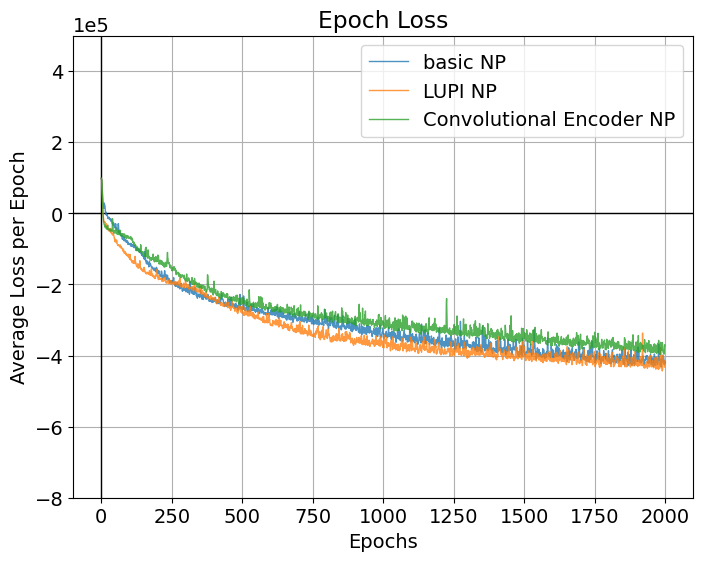

In [14]:
mpl.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.size": 14,
        "figure.figsize": [8, 6],
        "lines.linewidth": 1,
        "lines.markersize": 8,
        "legend.fontsize": "medium",
        "axes.labelsize": "medium",
        "xtick.labelsize": "medium",
        "ytick.labelsize": "medium",
    }
)

plot_losses(loss=loss, lupi_loss=lupi_loss, conv_loss=conv_loss, plot_moving_average=False)


#### Metric 3: Heatmaps for Comparison



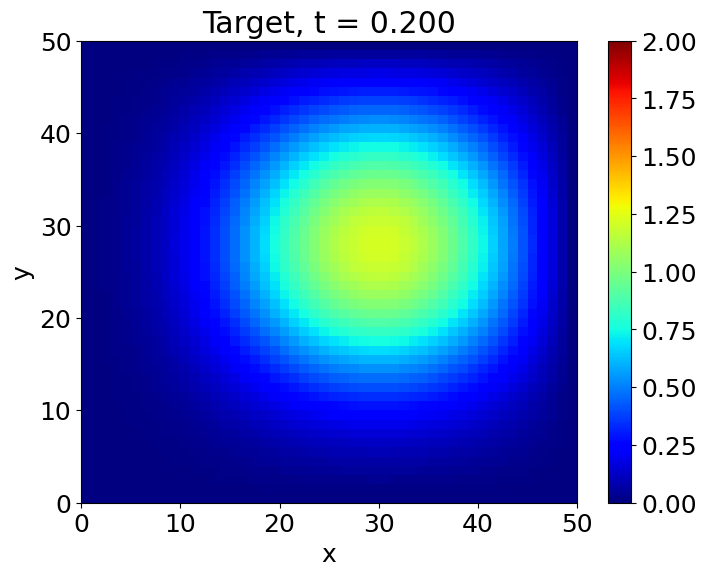

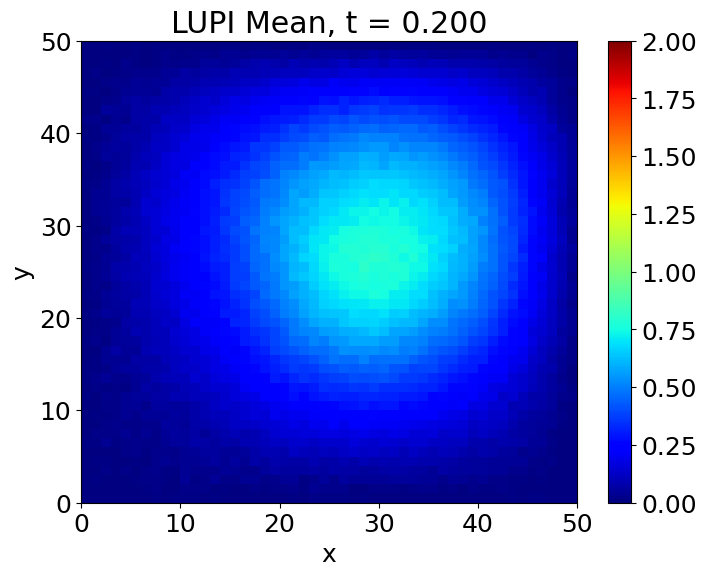

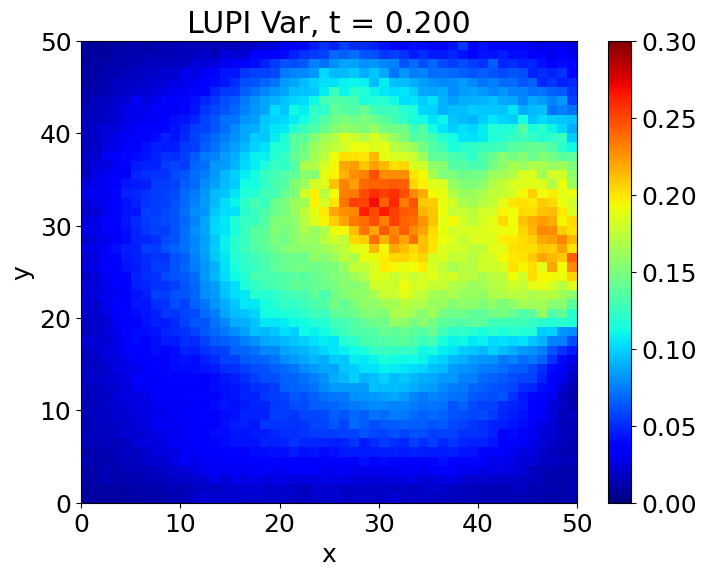

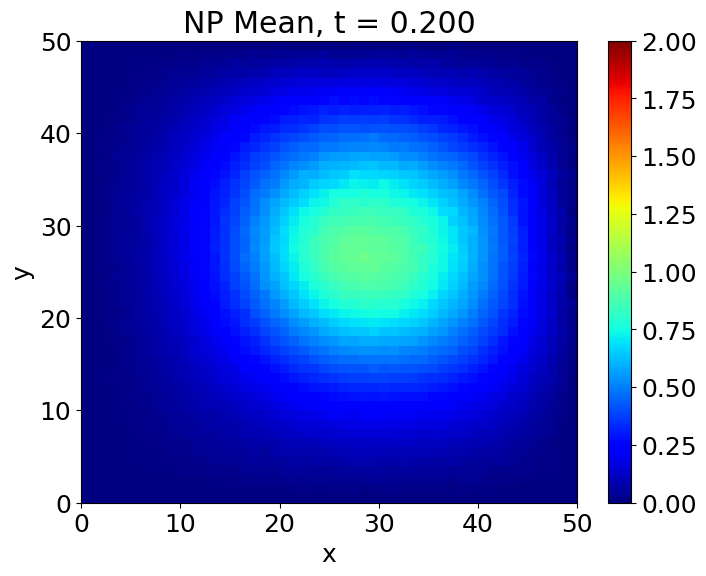

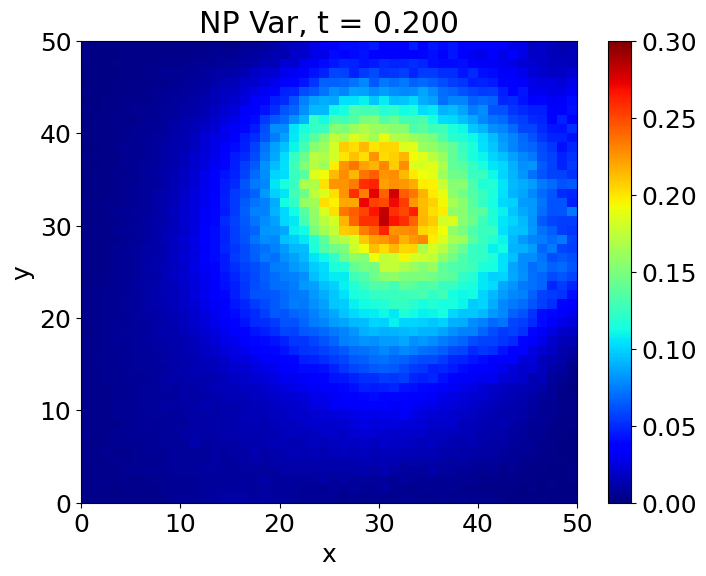

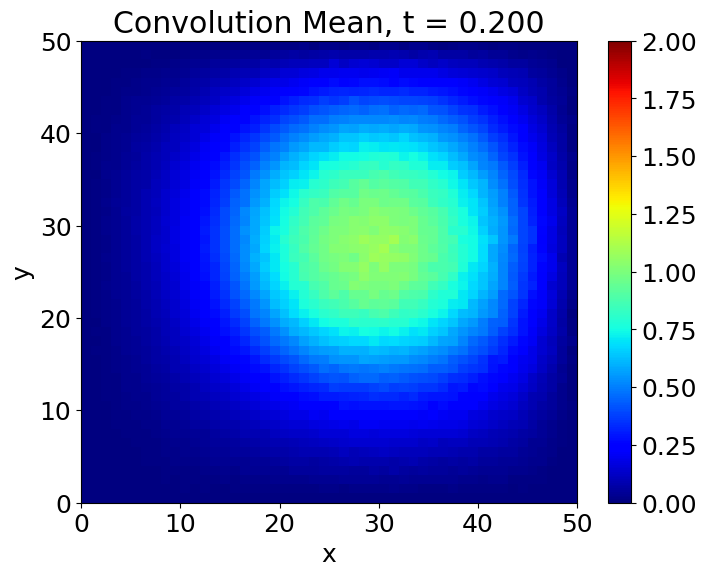

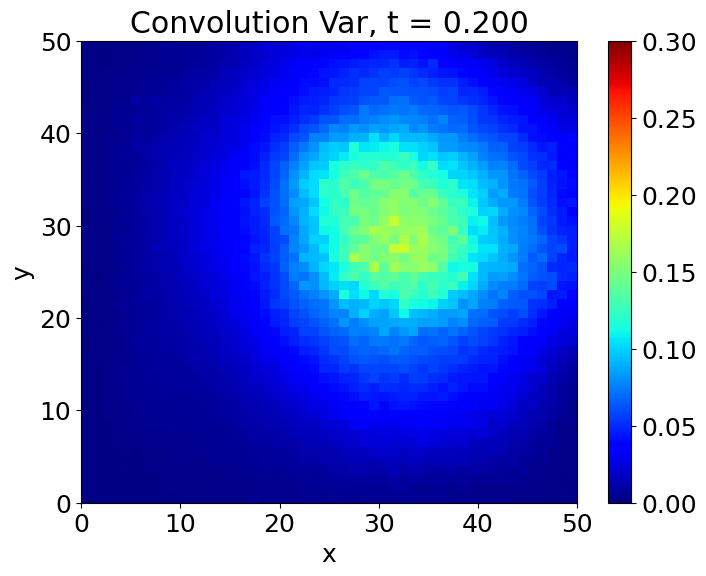

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [19]:
mpl.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.size": 18,
        "figure.figsize": [8, 6],
        "lines.linewidth": 1,
        "lines.markersize": 8,
        "legend.fontsize": "medium",
        "axes.labelsize": "medium",
        "xtick.labelsize": "medium",
        "ytick.labelsize": "medium",
    }
)

visualise_model_solution(y_target, 100, title='Target', vmin=0.0, vmax=2.0)
visualise_model_solution(lupi_y_mean, 100, title='LUPI Mean', vmin=0.0, vmax=2.0)
visualise_model_solution(lupi_y_var, 100, title='LUPI Var', vmin=0.0, vmax=0.3)
visualise_model_solution(y_mean, 100, title='NP Mean', vmin=0.0, vmax=2.0)
visualise_model_solution(y_var, 100, title='NP Var', vmin=0.0, vmax=0.3)
visualise_model_solution(conv_y_mean, 100, title='Convolution Mean', vmin=0.0, vmax=2.0)
visualise_model_solution(conv_y_var, 100, title='Convolution Var', vmin=0.0, vmax=0.3)


In [ ]:
''' 
PLOT OF INDIVIDUAL HEATMAPS AT SPECIFIC CHOSEN TIMES 
'''
def single_hm(result_k, k: int, max_iter_time: int, which_plot: str, title=None):
    if which_plot == "Target":
        i = 0
    elif which_plot == "Mean":
        i = 1
    elif which_plot == "Variance":
        i = 2
    else:
        print("Please put either Target, Mean or Variance for argument which_plot")
        raise KeyError

    # Clear the current plot figure
    plt.clf()
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    if title is None:
        plt.title(
            "Temperature at t = {:.3f} unit time, {}".format(
                k / max_iter_time, which_plot
            )
        )
    else:
        plt.title("{}, t = {:.3f}".format(title, k / max_iter_time))
    plt.pcolormesh(result_k[i], cmap=plt.cm.jet, vmin=0, vmax=2.0)
    plt.colorbar()
    plt.show()
    return plt

chosen_time_step = int(15)

single_hm(
    result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Target', 
    title='Target Solution'
)

single_hm(
    result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Mean', 
    title='NP Mean'
)

single_hm(
    result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Variance', 
    title='NP Variance'
)

single_hm(
    lupi_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Mean', 
    title='LUPI Mean'
)

single_hm(
    lupi_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Variance', 
    title='LUPI Variance'
)

single_hm(
    conv_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Mean', 
    title='Conv Mean'
)

single_hm(
    conv_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Variance', 
    title='Conv Variance'
)


In [ ]:
''' 
PLOTS SIDE BY SIDE:

        TARGET          MEAN            VARIANCE

FOR VARIOUS TIMES SPECIFIED IN THE LISTS
'''


for k in [0, 10, 50, 99]:
    print("FLAT NP \n")
    plotheatmap(result, k, dimensions['max_iter_time'], mean_var_only=False)
    # plotheatmap(result_noise, k, dimensions['max_iter_time'], mean_var_only=True)

for k in [0, 10, 50, 99]:
    print("\n\n\n LUPI NP \n")
    plotheatmap(lupi_result, k, dimensions['max_iter_time'], mean_var_only=False)
    # plotheatmap(lupi_result_noise, k, dimensions['max_iter_time'], mean_var_only=True)

for k in [0, 10, 50, 99]:
    print("\n\n\n CONV NP \n")
    plotheatmap(conv_result, k, dimensions['max_iter_time'], mean_var_only=False)
    # plotheatmap(conv_result_noise, k, dimensions['max_iter_time'], mean_var_only=True)
    



#### Metric 4: Plot Residuals and compare to Variance

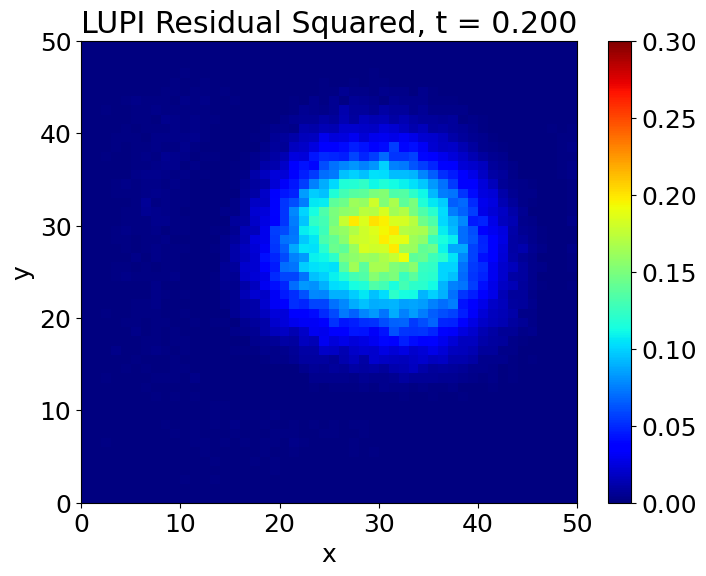

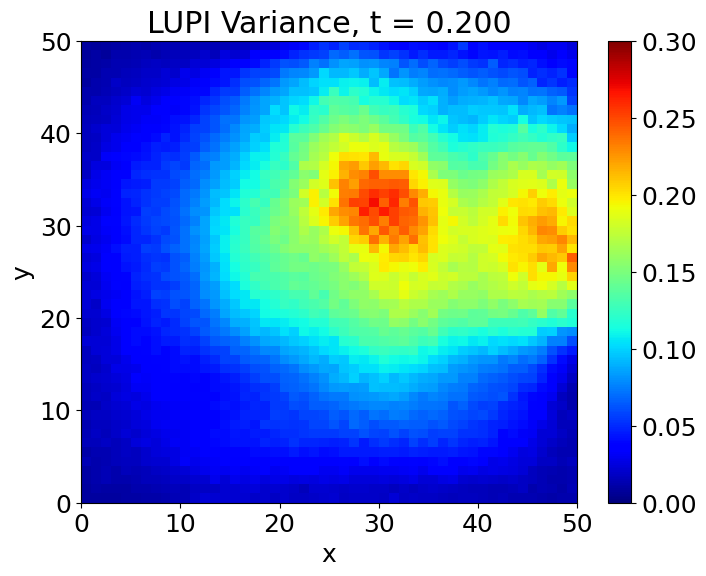

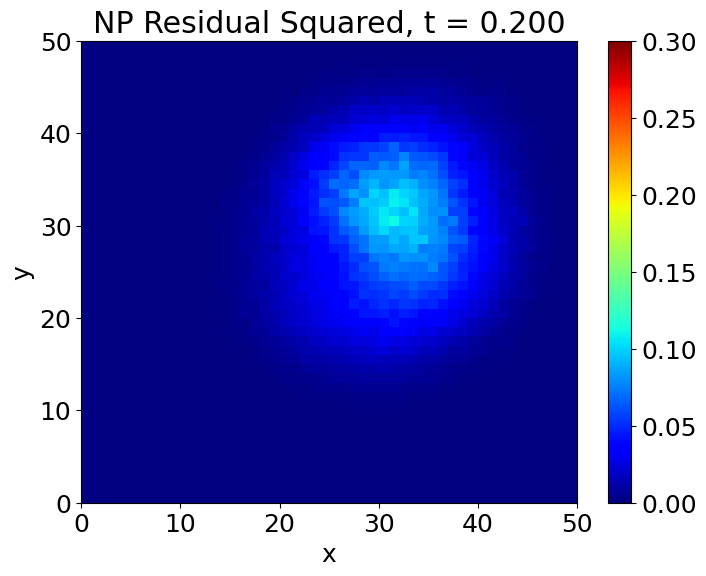

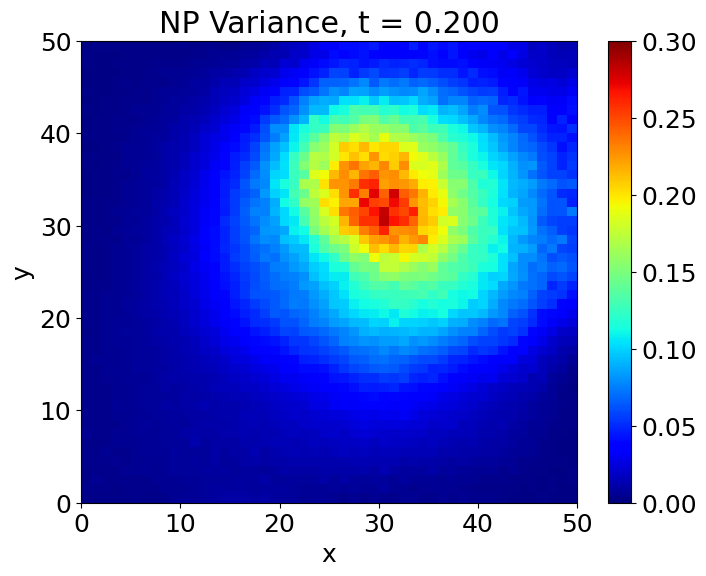

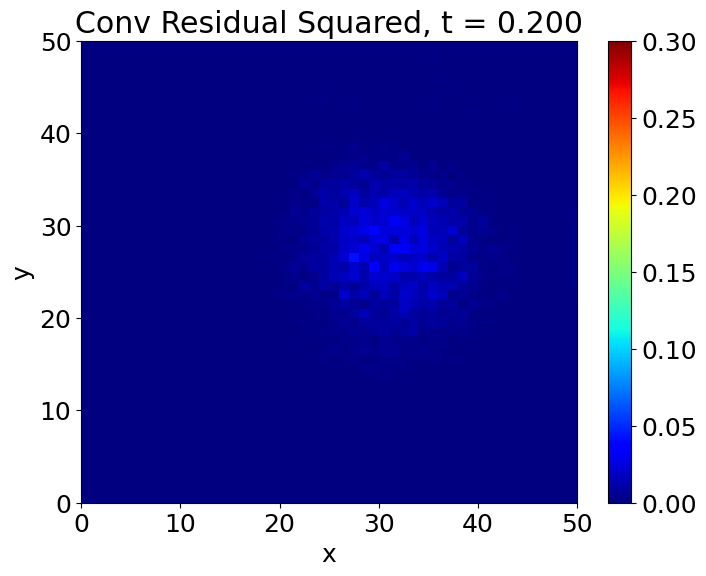

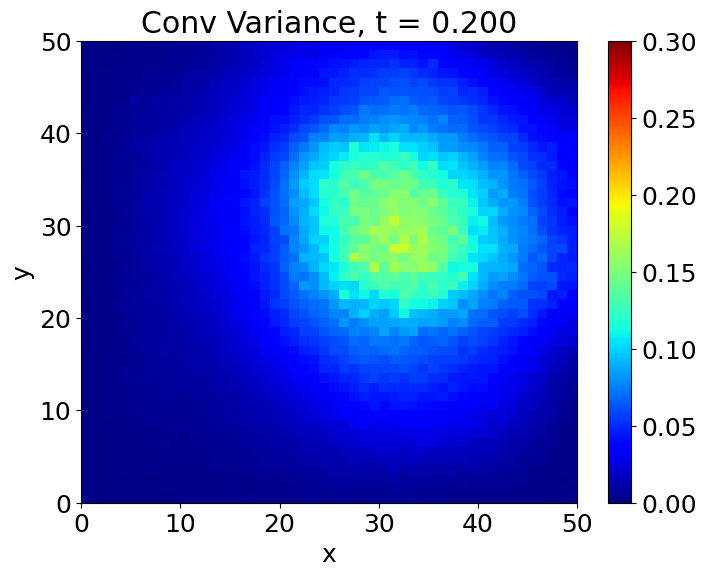

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [16]:
visualise_model_solution((lupi_y_mean - y_target)**2, 100, title='LUPI Residual Squared', vmin=0.0, vmax=0.3)
visualise_model_solution(lupi_y_var, 100, title='LUPI Variance', vmin=0.0, vmax=0.3)
visualise_model_solution((y_mean - y_target)**2, 100, title='NP Residual Squared', vmin=0.0, vmax=0.3)
visualise_model_solution(y_var, 100, title='NP Variance', vmin=0.0, vmax=0.3)
visualise_model_solution((conv_y_mean - y_target)**2, 100, title='Conv Residual Squared', vmin=0.0, vmax=0.3)
visualise_model_solution(conv_y_var, 100, title='Conv Variance', vmin=0.0, vmax=0.3)

In [ ]:
for i in [0, 5, 25, 75]:
    plot_residuals(conv_result, i, dimensions['max_iter_time'])

#### Noisey Input to Neural Process

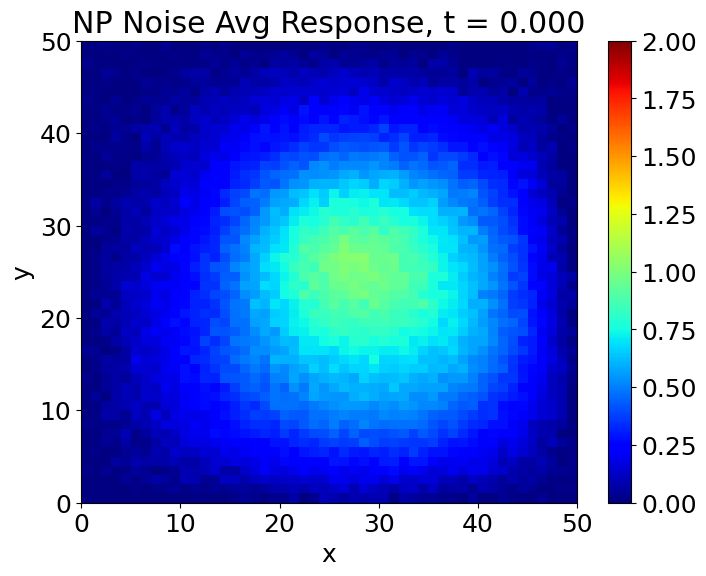

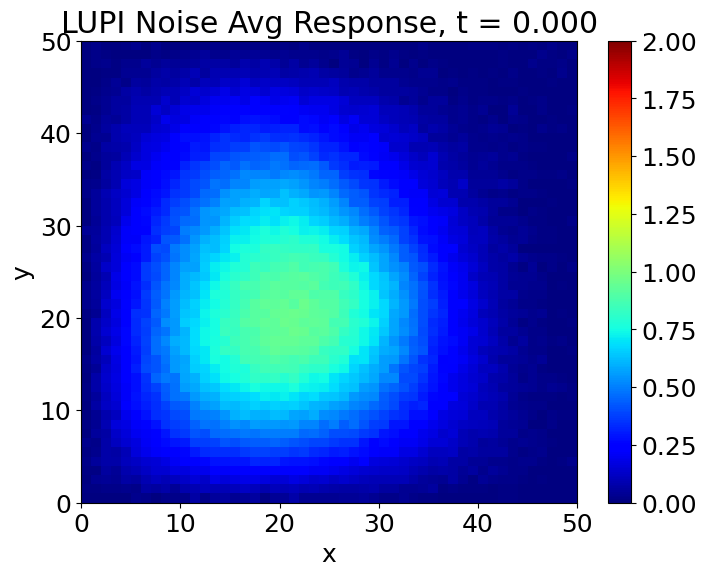

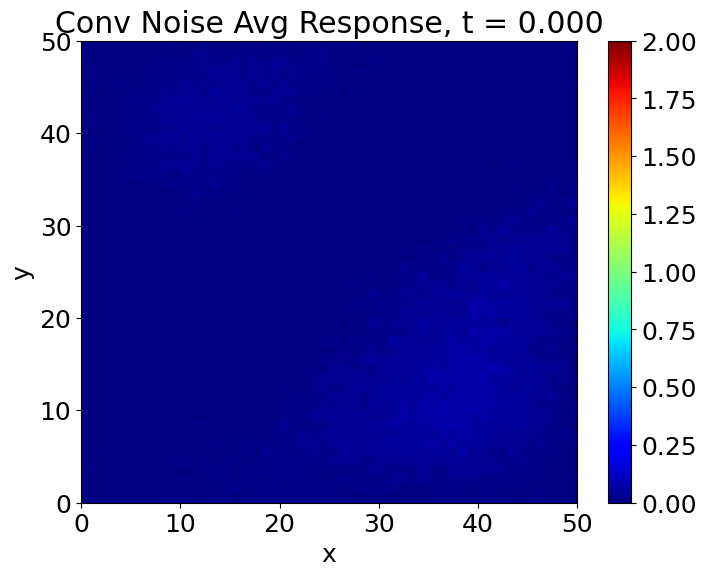

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [17]:
visualise_model_solution(y_noise, 0, title='NP Noise Avg Response')
visualise_model_solution(lupi_y_noise, 0, title='LUPI Noise Avg Response')
visualise_model_solution(conv_y_noise, 0, title='Conv Noise Avg Response')


#### Heatmap Animation GIF

In [ ]:
"""
SINGLE HEATMAP GIF
------------------

- target = True, variance = False gives the target solution 
- target = False, variance = True gives the variance in the prediction
- target = False, variance = False gives the mean of the prediction
"""

def plot_and_save_heatmaps(noise: bool, architecture: str):
    ''' 
    Is there a way to plot this gif without defining a function inside a function?
    '''
    assert architecture in ['flat', 'LUPI', 'conv']

    if noise:
        for which_plot in ['Target', 'Mean', 'Variance']:

            def animate(k, max_iter_time: int, which_plot: str):
                single_hm(conv_result[k], k, dimensions['max_iter_time'], which_plot=which_plot)

            anim = FuncAnimation(
                plt.figure(),
                animate,
                interval=1,
                frames=dimensions['max_iter_time'],
                repeat=False,
                fargs=(dimensions['max_iter_time'], which_plot)
            )
            anim.save("./animation_results/noisey_{}_{}.gif".format(architecture, which_plot))
    else:
        for which_plot in ['Target', 'Mean', 'Variance']:

                def animate(k, max_iter_time: int, which_plot: str):
                    single_hm(conv_result[k], k, dimensions['max_iter_time'], which_plot=which_plot)

                anim = FuncAnimation(
                    plt.figure(),
                    animate,
                    interval=1,
                    frames=dimensions['max_iter_time'],
                    repeat=False,
                    fargs=(dimensions['max_iter_time'], which_plot)
                )
                anim.save("./animation_results/{}_{}.gif".format(architecture, which_plot))


plot_and_save_heatmaps(noise=False, architecture='conv')

#### Energy and Entropy 

In [ ]:
# def get_energy_and_entropy(result):
#     max_iter_time = len(result)
#     grid_size = result[0][0].shape[0]
#     avg_energy_target = torch.full((max_iter_time,), np.nan)
#     avg_energy_mean = torch.full((max_iter_time,), np.nan)
#     avg_energy_var = torch.full((max_iter_time,), np.nan)
#     avg_entropy_target = torch.full((max_iter_time,), np.nan)
#     avg_entropy_mean = torch.full((max_iter_time,), np.nan)
#     avg_entropy_var = torch.full((max_iter_time,), np.nan)

#     for k in range(max_iter_time):
#         avg_energy_target[k] = torch.sum(result[k][0]) / (grid_size**2)
#         avg_energy_mean[k] = np.sum(result[k][1]) / (grid_size**2)
#         avg_energy_var[k] = np.sum(result[k][2]) / (grid_size**2)
#         avg_entropy_target[k] = torch.count_nonzero(result[k][0]) / (grid_size**2)
#         avg_entropy_mean[k] = np.count_nonzero(result[k][1]) / (grid_size**2)
#         avg_entropy_var[k] = np.count_nonzero(result[k][2]) / (grid_size**2)

#     return (
#         (avg_energy_target, avg_energy_mean, avg_energy_var),
#         (avg_entropy_target, avg_entropy_mean, avg_entropy_var),
#     )
    
# (
#     (target_energy, mean_energy, var_energy),
#     (target_entropy, mean_entropy, var_entropy),
# ) = get_energy_and_entropy(result)

# (
#     (lupi_target_energy, lupi_mean_energy, lupi_var_energy),
#     (lupi_target_entropy, lupi_mean_entropy, lupi_var_entropy),
# ) = get_energy_and_entropy(lupi_result)

# (
#     (conv_target_energy, conv_mean_energy, conv_var_energy),
#     (conv_target_entropy, conv_mean_entropy, conv_var_entropy),
# ) = get_energy_and_entropy(conv_result)

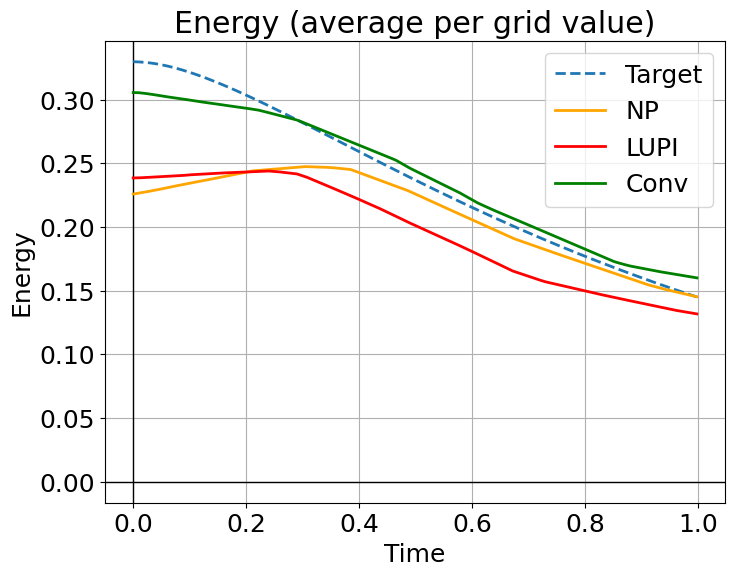

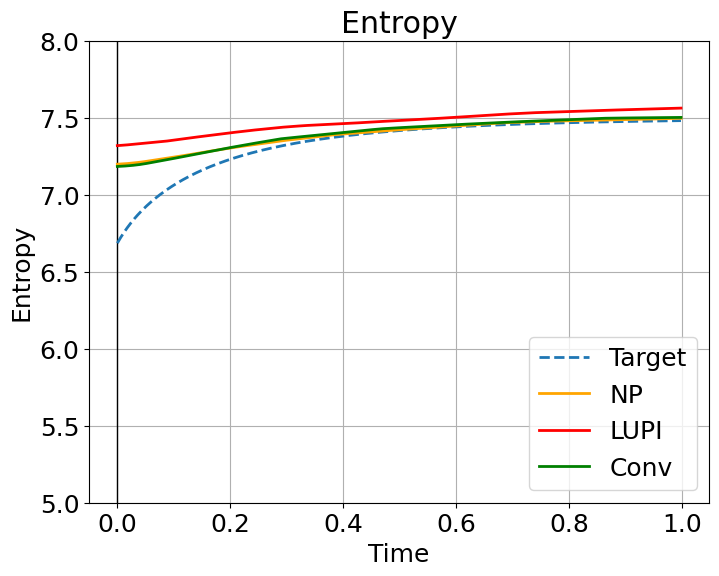

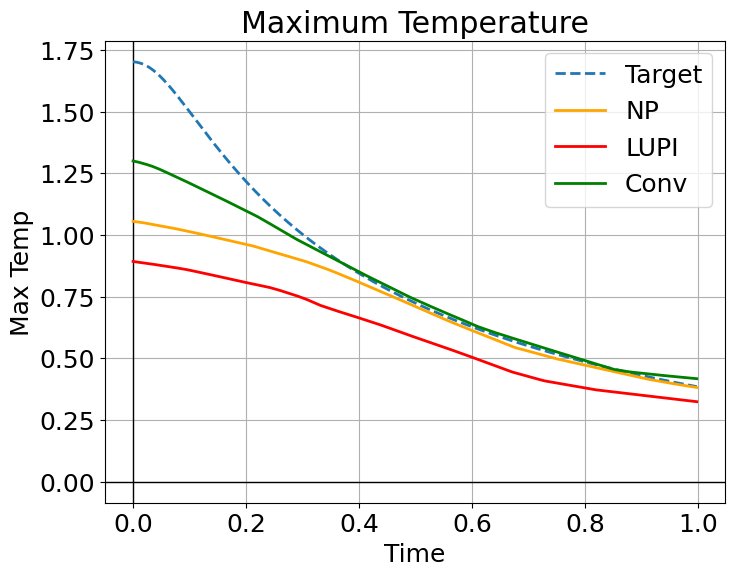

In [20]:
target_max_temp, target_energy, target_entropy = get_pi(y_target)
np_max_temp, np_energy, np_entropy = get_pi(y_mean)
lupi_max_temp, lupi_energy, lupi_entropy = get_pi(lupi_y_mean)
conv_max_temp, conv_energy, conv_entropy = get_pi(conv_y_mean)

plot_pi_data(target_energy, np_energy, lupi_energy, conv_energy, title='Energy (average per grid value)', xlabel='Time', ylabel='Energy')
plot_pi_data(target_entropy, np_entropy, lupi_entropy, conv_entropy, title='Entropy', xlabel='Time', ylabel='Entropy')
plot_pi_data(target_max_temp, np_max_temp, lupi_max_temp, conv_max_temp, title='Maximum Temperature', xlabel='Time', ylabel='Max Temp')



# Fix this bug for GIF

In [ ]:
y_out = y_out.reshape((dimensions['max_iter_time'], grid_size, grid_size))
var_out = var_out.reshape((dimensions['max_iter_time'], grid_size, grid_size))
y_target = y_target.reshape((dimensions['max_iter_time'], grid_size, grid_size))

result = [
    (y_target[id, :, :], y_out[id, :, :], var_out[id, :, :])
    for id in range(y_target.shape[0])
]

# from heat_diffusion_dataset import Initial_Conditions, Diffusion_Data
# import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


def plotheatmap(result_k, k, axes):
    # Clear the current plot figure
    plt.clf()
    ax1, ax2, ax3 = axes

    # plt.title(f"Temperature at t = {k * delta_t:.3f} unit time")
    ax1.set_title(f"Target at t = {k * 4 * np.pi / dimensions['max_iter_time']:.3f} unit time")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax2.set_title(
        f"Predicted Mean at t = {k * 4 * np.pi / dimensions['max_iter_time']:.3f} unit time"
    )
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")

    ax3.set_title(f"Predicted Var at t = {k * 4 * np.pi / dimensions['max_iter_time']:.3f} unit time")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")

    # This is to plot u_k (u at time-step k)
    ax1.pcolormesh(result_k[0], cmap=plt.cm.jet, vmin=-1.1, vmax=1.1)
    ax2.pcolormesh(result_k[1], cmap=plt.cm.jet, vmin=-1.1, vmax=1.1)
    ax3.pcolormesh(result_k[2], cmap=plt.cm.jet, vmin=-1.1, vmax=1.1)

    return fig, axes


def animate(k):
    plotheatmap(result[k], k)

    # if not plot_var and not target:
    #     plotheatmap(y_out[k], k, delta_t)
    # elif plot_var and not target:
    #     plotheatmap(var_out[k], k, delta_t)
    # else:
    #     plotheatmap(y_target[k], k, delta_t)


# plot_var = False
# target = False
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

anim = animation.FuncAnimation(
    fig, animate, interval=1, frames=dimensions['max_iter_time'], repeat=False, fargs=(axes,)
)
anim.save("harmonics_solution.gif")

# plot_var=True
# anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False, fargs=None)
# anim.save("harmonics_variance.gif")

# target=True
# anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False, fargs=None)
# anim.save("harmonics_target.gif")